In [1]:
import os
import shutil

# Remover o diretório __pycache__ se existir
if os.path.exists('__pycache__'):
    shutil.rmtree('__pycache__')

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D, Conv1D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, recall_score, precision_score, precision_recall_curve, roc_curve, classification_report, auc
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import sys
sys.path.append('/eos/home-i03/m/mdemelop/SWAN_projects/ML/Seminario')

from particle_types import ParticleType
from jet_labels import create_labels_single_column, ParticleType
from models import model_efp, build_model_a, build_model_b, build_model_a_wBN
from sklearn.utils import shuffle
from utilities import save_model
from data_loaders import load_data_top_tagging, load_data_top_tagging_wR

2024-06-22 18:27:42.314749: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-22 18:27:42.387303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
root_data_folder = '/eos/home-i03/m/mdemelop/SWAN_projects/ML/Seminario/Data/'

In [15]:
# Calculating X_train, y_train, X_val, y_val, X_test and y_test 
# Loads the data for the Top-tagging, take half of the quark and 
# gluons datasets and shuffle by load_data_top_tagging


# Without mean DeltaRij as add feature 
# X_train, y_train = load_data_top_tagging(
#     quark_data_path=f"{root_data_folder}/Trainning/q_jets_efps_d5_primed.npy", 
#     gluon_data_path=f"{root_data_folder}/Trainning/g_jets_efps_d5_primed.npy",
#     top_data_path=f"{root_data_folder}/Trainning/t_jets_efps_d5_primed.npy")

# X_val, y_val = load_data_top_tagging(
#     quark_data_path=f"{root_data_folder}/Validation/q_jets_efps_d5_primed.npy", 
#     gluon_data_path=f"{root_data_folder}/Validation/g_jets_efps_d5_primed.npy",
#     top_data_path=f"{root_data_folder}/Validation/t_jets_efps_d5_primed.npy")


# X_test, y_test = load_data_top_tagging(
#     quark_data_path=f"{root_data_folder}/Test/q_jets_efps_d5_primed.npy", 
#     gluon_data_path=f"{root_data_folder}/Test/g_jets_efps_d5_primed.npy",
#     top_data_path=f"{root_data_folder}/Test/t_jets_efps_d5_primed.npy")



# With mean DeltaRij as add feature _wRwNconst

print("Loading trainning data...")
X_train, y_train = load_data_top_tagging_wR(
    quark_data_path=f"{root_data_folder}/Trainning/q_jets_efps_d5_primed.npy", 
    gluon_data_path=f"{root_data_folder}/Trainning/g_jets_efps_d5_primed.npy",
    top_data_path=f"{root_data_folder}/Trainning/t_jets_efps_d5_primed.npy",
    mean_deltaRij_quark_path=f"{root_data_folder}/Trainning/mean_deltaRij_q.npy",
    mean_deltaRij_gluon_path=f"{root_data_folder}/Trainning/mean_deltaRij_g.npy",
    mean_deltaRij_top_path=f"{root_data_folder}/Trainning/mean_deltaRij_t.npy")

print("Loading validation data...")
X_val, y_val = load_data_top_tagging_wR(
    quark_data_path=f"{root_data_folder}/Validation/q_jets_efps_d5_primed.npy", 
    gluon_data_path=f"{root_data_folder}/Validation/g_jets_efps_d5_primed.npy",
    top_data_path=f"{root_data_folder}/Validation/t_jets_efps_d5_primed.npy",
    mean_deltaRij_quark_path=f"{root_data_folder}/Validation/mean_deltaRij_q.npy",
    mean_deltaRij_gluon_path=f"{root_data_folder}/Validation/mean_deltaRij_g.npy",
    mean_deltaRij_top_path=f"{root_data_folder}/Validation/mean_deltaRij_t.npy")

print("Loading testing data...")
X_test, y_test = load_data_top_tagging_wR(
    quark_data_path=f"{root_data_folder}/Test/q_jets_efps_d5_primed.npy", 
    gluon_data_path=f"{root_data_folder}/Test/g_jets_efps_d5_primed.npy",
    top_data_path=f"{root_data_folder}/Test/t_jets_efps_d5_primed.npy",
    mean_deltaRij_quark_path=f"{root_data_folder}/Test/mean_deltaRij_q.npy",
    mean_deltaRij_gluon_path=f"{root_data_folder}/Test/mean_deltaRij_g.npy",
    mean_deltaRij_top_path=f"{root_data_folder}/Test/mean_deltaRij_t.npy")





print('OK')

Loading trainning data...
Loading validation data...
Loading testing data...
OK


In [16]:

# Assuming y_train, y_val, y_test are your label arrays
# Convert labels to categorical (one-hot encoding)
# just for b model
#y_train_categorical = to_categorical(y_train)
#y_val_categorical = to_categorical(y_val)
#y_test_categorical = to_categorical(y_test)



# Normalize the data (example using StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Expand the dimension of inputs to the format expected by Conv1D model
X_train_scaled = np.expand_dims(X_train_scaled, axis=-1)
X_val_scaled = np.expand_dims(X_val_scaled, axis=-1)
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)



# train -> used for training the model
# val -> used for validation, tuning hyperparameters, and evaluating model performance during training
# test -> test set, used for evaluating the final model performance

# Checking sizes of the datasets
print(f'Training set size: {X_train_scaled.shape[0]}')
print(f'Validation set size: {X_val_scaled.shape[0]}')
print(f'Test set size: {X_test_scaled.shape[0]}')
print(f'X_train.shape[1]:', X_train_scaled.shape[1])

quark_data_path=f"{root_data_folder}/Trainning/q_jets_efps_d5_primed.npy"
data_array = np.load(quark_data_path)
array_shape = data_array.shape

print("Shape of data_array:", array_shape)
print(f'X_train.shape:', X_train_scaled.shape)

Training set size: 254256
Validation set size: 44871
Test set size: 52789
X_train.shape[1]: 55
Shape of data_array: (123315, 54)
X_train.shape: (254256, 55, 1)


In [17]:
# Build and compile the model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
model_a_wBN = build_model_a_wBN(input_shape)

##binary_crossentropy for model a 
#categorical_crossentropy for model b 
model_a_wBN.compile(Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model_a_wBN.fit(
    #X_train_scaled, y_train_categorical, #just for b model
    X_train_scaled, y_train,
    epochs=100,  # Definir o número total de épocas desejadas
    batch_size=50,
    #validation_data=(X_val_scaled, y_val_categorical), #just for b model
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
#test_loss, test_accuracy, test_auc = model_b.evaluate(X_test_scaled, y_test)
test_loss, test_accuracy, test_auc = model_a_wBN.evaluate(X_test_scaled, y_test) # b model
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test AUC: {test_auc:.4f}')

# Save the model 
save_model(model_a_wBN, history, 'top_model_a_wBN_wR')

Epoch 1/100


2024-06-22 20:28:45.491797: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-22 20:28:45.496630: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


5086/5086 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.8917 - auc_3: 0.9552

2024-06-22 20:29:46.618179: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


5086/5086 [==============================] - 71s 12ms/step - loss: 0.2688 - accuracy: 0.8917 - auc_3: 0.9552 - val_loss: 0.2439 - val_accuracy: 0.9017 - val_auc_3: 0.9695
Epoch 2/100
5086/5086 [==============================] - 66s 13ms/step - loss: 0.2274 - accuracy: 0.9097 - auc_3: 0.9679 - val_loss: 0.2171 - val_accuracy: 0.9133 - val_auc_3: 0.9707
Epoch 3/100
5086/5086 [==============================] - 63s 12ms/step - loss: 0.2217 - accuracy: 0.9122 - auc_3: 0.9694 - val_loss: 0.2287 - val_accuracy: 0.9103 - val_auc_3: 0.9701
Epoch 4/100
5086/5086 [==============================] - 62s 12ms/step - loss: 0.2193 - accuracy: 0.9132 - auc_3: 0.9701 - val_loss: 0.2176 - val_accuracy: 0.9126 - val_auc_3: 0.9718
Epoch 5/100
5086/5086 [==============================] - 63s 12ms/step - loss: 0.2168 - accuracy: 0.9135 - auc_3: 0.9708 - val_loss: 0.2115 - val_accuracy: 0.9151 - val_auc_3: 0.9723
Epoch 6/100
5086/5086 [==============================] - 62s 12ms/step - loss: 0.2153 - accuracy:

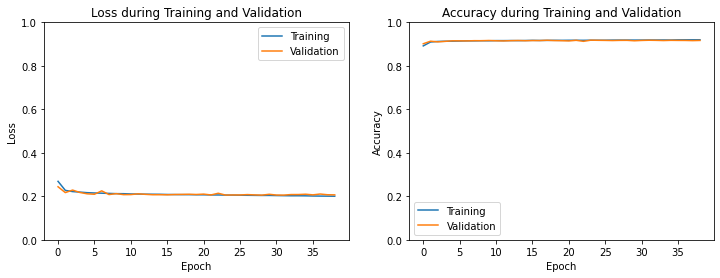

In [23]:
# Plotting loss during training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0., 1.)
plt.legend()

# Plotting accuracy during training
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0., 1.)
plt.legend()

plt.show()

In [ ]:
# Classification report on the test set
y_pred = (model_a_wBN.predict(X_test_scaled) > 0.5).astype("int32")
print("Classification Report - Test Set")
print(classification_report(y_test, y_pred, target_names=["Not Top", "Top"]))


1125/1650 [===================>..........] - ETA: 1s

In [ ]:
# Predictions on the training set
y_pred_train = (model_a_wBN.predict(X_train_scaled) > 0.5).astype("int32")
print("Classification Report - Training Set")
print(classification_report(y_train, y_pred_train, target_names=["Not Top", "Top"]))


In [ ]:
# Predicted probabilities on the test set
y_pred_prob_test = model_a_wBN.predict(X_test_scaled).ravel()

# ROC curve and AUC on the test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting ROC curve for the test set
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Predicted probabilities on the training set
y_pred_prob_train = model_a_wBN.predict(X_train_scaled).ravel()

# ROC curve and AUC on the training set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)

# Plotting ROC curve for the training set
plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_train:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Training Set')
plt.legend(loc='lower right')
plt.show()